## Import + данные

In [18]:
!pip install tsfresh --q
!pip install catboost
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 14.2 MB/s eta 0:00:00


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy import stats

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from IPython.display import clear_output
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from prophet import Prophet
from arch.unitroot import PhillipsPerron
# from pyts.transformation import ShapeletTransform

from statsmodels.tsa.stattools import adfuller
from tsfresh import extract_features

from catboost import CatBoostClassifier
# import optuna

In [ ]:
data = pd.read_parquet('train.parquet')

In [ ]:
data.isna().sum().sum()

0

In [ ]:
data

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [ ]:
def find_min_max(row):
    min_date = min(row['dates'])
    max_date = max(row['dates'])
    min_value = min(row['values'])
    max_value = max(row['values'])

    return pd.Series({'min_date': min_date, 'max_date': max_date, 'min_value': min_value, 'max_value': max_value})

min_max_data = data.apply(find_min_max, axis=1)
result_data = pd.concat([data, min_max_data], axis=1)

In [ ]:
result_data.isna().sum().sum()

176

In [ ]:
result_data[result_data['min_date'].isna()]

,id,dates,values,label,min_date,max_date,min_value,max_value


In [ ]:
result_data[result_data['min_value'].isna()]

,id,dates,values,label,min_date,max_date,min_value,max_value
1979,95215,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0,2016-03-01,2023-11-01,NaN,NaN
2328,56091,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0,2020-04-01,2023-11-01,NaN,NaN
3244,63162,"[2017-12-01, 2018-01-01, 2018-02-01, 2018-03-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,2017-12-01,2021-04-01,NaN,NaN
3315,29359,"[2016-11-01, 2016-12-01, 2017-01-01, 2017-02-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,2016-11-01,2021-01-01,NaN,NaN
3873,12983,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,2016-02-01,2022-06-01,NaN,NaN
...,...,...,...,...,...,...,...,...
75207,61409,"[2018-12-01, 2019-01-01, 2019-02-01, 2019-03-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0,2018-12-01,2022-07-01,NaN,NaN
75743,28644,"[2019-07-01, 2019-08-01, 2019-09-01, 2019-10-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,2019-07-01,2023-05-01,NaN,NaN
76789,31408,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0,2020-04-01,2023-10-01,NaN,NaN
77792,67417,"[2017-04-01, 2017-05-01, 2017-06-01, 2017-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0,2017-04-01,2020-06-01,NaN,NaN


видим что для 88 столбцов values пустые пока что дропнем их, если все будет плохо подумаем могут ли они дать инфу

In [ ]:
result_data = result_data[~result_data['min_value'].isna()]

In [ ]:
result_data.isna().sum().sum()

0

In [ ]:
result_data.reset_index(drop=True,inplace=True)

## работа с данными

первое что приходит в голову это с помощью `tsfresh` или же нейронкой вытащить фичи (feature extraction) и уже будет классическая задача со столбцами из фич и таргетом (что можно решить бустингом)

### стационарность



сначала проверим что все timeseries стационарны, с помощью теста `Phillip Perron`'a

In [ ]:
i = np.random.randint(len(data))
x = data.loc[i,'dates']
y = data.loc[i,'values']
parts = int(len(y)/3)

part_1, part_2, part_3 = y[0:parts], y[parts:(
    parts*2)], y[(parts*2):(parts*3)]

mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()


var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()


print('mean1=%f,\nmean2=%f, \nmean2=%f\n' % (mean_1, mean_2, mean_3))

print('variance1=%f,\nvariance2=%f, \nvariance2=%f' % (var_1, var_2, var_3))

mean1=0.134231,
mean2=-0.080000, 
mean2=0.568077

variance1=1.298809,
variance2=1.950969, 
variance2=1.013246


изначально были мысли проверять тестом `Dickey_fuller`, но, почитав, показалось что PP прикольнее и лучше

In [ ]:
i = np.random.randint(len(data))
y = data.loc[i,'values']
res = adfuller(y)

print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])


Augmneted Dickey_fuller Statistic: -4.166611
p-value: 0.000750


In [ ]:
# temp = result_data.loc[:len(result_data)//2]
def pptest(row):
    try: ## выдавало ошибку, но вроде все ок
        y = row['values']
        if len(y) == 0:
            return np.nan
        res = PhillipsPerron(y)
        return res.pvalue
    except:
        print(row)

temp = result_data.copy()
res = temp.apply(pptest,axis=1) ### аутпут такой тк запускал ячейку не запускав прошлые, а сами данные с pvalues я просто сохранил в другой файл

NameError: name 'result_data' is not defined

In [ ]:
(res <0.05).sum()

73834

In [ ]:
result_data.shape[0] - (res <0.05).sum()

6078

В контексте теста Филлипса-Перрона нулевая гипотеза заключается в том, что временной ряд имеет единичный корень, то есть он является нестационарным.

видим что мы отвергнули гипотезу столько раз, т.е большенство наших рядов стационарны

In [ ]:
res_data = pd.concat([result_data,res],axis=1)

In [ ]:
res_data.to_parquet('train_pval_pp.parquet')

C:\Users\bekao\anaconda3\Lib\site-packages\pandas\io\parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [ ]:
# adf_data = pd.read_parquet('train_pval_adftest.parquet') ## проводился аналогинчые тест адф
pp_data= pd.read_parquet('train_pval_pp.parquet').rename(columns={'0':'pval'}).reset_index(drop=True)

In [ ]:
stat = pp_data[pp_data['pval']>0.05]

### избавляемся от стационарности

приводить к стационарным решил простым способом преобразование бокса-кокса для стабилизации дисперси + дифференцирование для снятие тренда

0.0


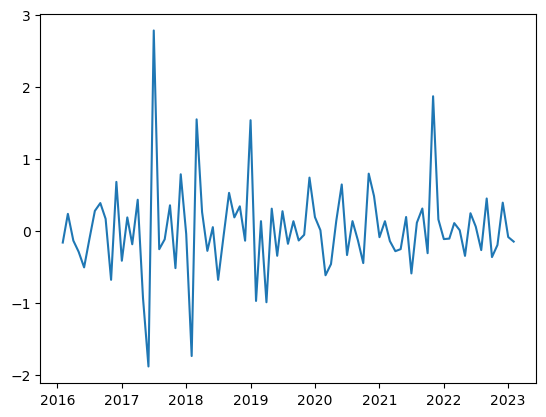

In [ ]:
i = np.random.randint(len(stat))

x = stat.iloc[i]['dates']
y = stat.iloc[i]['values']
y = y +abs(min(y))+1e-6
y,_ = stats.boxcox(y)
y = np.diff(y)
print(PhillipsPerron(y).pvalue)
y=np.insert(y, 0, np.nan)
# print(i)
plt.plot(x,y)


In [ ]:
def log_diff(row):
    y = row['values']
    y = y +abs(min(y))+1e-6
    y,_ = stats.boxcox(y)
    y = np.diff(y)
    y=np.insert(y, 0, np.nan)
    return y

In [ ]:
res = pp_data[pp_data['pval']>0.05].apply(log_diff, axis=1)

In [ ]:
data = pp_data.copy()
data[data['pval']>0.05]['values'] = res
data.drop(['pval','max_date','min_date','min_value','max_value'],inplace=True,axis=1)

C:\Users\bekao\AppData\Local\Temp\ipykernel_1804\332241064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['pval']>0.05]['values'] = res


In [ ]:
data

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79907,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79908,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79909,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79910,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [ ]:
data.to_parquet('train_logged.parquet')

### feature extraction

приводим данные к 'длинному' формату, тк в библиотеке `tsfresh` feature extractor просит такие данные

In [ ]:
temp = data.copy()
temp['dates'] = temp['dates'].apply(lambda x: x.tolist())
temp['values'] = temp['values'].apply(lambda x: x.tolist())

temp_long = temp.explode(['dates', 'values'])
temp_long['dates'] = pd.to_datetime(temp_long['dates'])
temp_long['values'] = temp_long['values'].astype(float)
# temp_long.to_parquet('long_data.parquet')

In [ ]:
temp_long.isna().sum()

id        0
dates     0
values    0
label     0
dtype: int64

для начала было решенно использовать только 3к, тк процесс не быстрый а проверить адекватность работы хочется побыстрее

In [ ]:
data = pd.read_parquet('train_logged.parquet')
temp_long = pd.read_parquet('long_data.parquet').loc[:3000]
temp = data.loc[:3000]

In [ ]:
extracted_features = extract_features(temp_long,column_id ='id', column_sort='dates',column_value='values')
extracted_features.to_parquet('features3л.parquet')

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [07:51<00:00, 47.12s/it]


In [ ]:
extracted_features

,values__variance_larger_than_standard_deviation,values__has_duplicate_max,values__has_duplicate_min,values__has_duplicate,values__sum_values,values__abs_energy,values__mean_abs_change,values__mean_change,values__mean_second_derivative_central,values__median,...,values__fourier_entropy__bins_5,values__fourier_entropy__bins_10,values__fourier_entropy__bins_100,values__permutation_entropy__dimension_3__tau_1,values__permutation_entropy__dimension_4__tau_1,values__permutation_entropy__dimension_5__tau_1,values__permutation_entropy__dimension_6__tau_1,values__permutation_entropy__dimension_7__tau_1,values__query_similarity_count__query_None__threshold_0.0,values__mean_n_absolute_max__number_of_maxima_7
44,1.0,0.0,0.0,1.0,2.570000,94.778500,1.457917,0.020833,-0.038617,0.250,...,1.267795,1.741524,2.865235,1.633575,2.709980,3.456163,3.752683,3.761200,NaN,2.552857
69,1.0,0.0,0.0,1.0,4.190000,124.342500,1.662542,-0.002542,0.013362,0.180,...,1.166457,1.718935,2.897357,1.788829,3.103238,3.852065,3.982128,3.988984,NaN,2.771429
118,1.0,0.0,0.0,1.0,-0.820000,90.836000,1.169245,0.012264,0.007885,0.045,...,1.129070,1.556872,2.799725,1.783568,2.959928,3.717942,3.891820,3.871201,NaN,2.724286
123,1.0,0.0,0.0,1.0,9.710000,84.928500,1.102500,-0.045577,0.007255,0.120,...,0.925780,1.481562,2.794980,1.771332,3.004223,3.693778,3.871201,3.850148,NaN,2.232857
226,1.0,0.0,0.0,1.0,-2.070000,80.725900,0.814062,-0.041250,-0.000079,0.000,...,0.772102,1.207157,2.815829,1.753897,2.972259,3.766974,4.001925,4.030544,NaN,2.025714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99851,1.0,0.0,0.0,1.0,-20.680000,175.649200,1.330222,0.023778,-0.010393,-0.200,...,0.731706,1.314846,2.931682,1.782349,3.093430,3.989673,4.373749,4.426342,NaN,2.761429
99853,1.0,0.0,0.0,1.0,-8.600000,124.224400,1.048519,-0.021358,0.005563,-0.355,...,0.224451,0.583280,2.510394,1.777652,3.020621,3.987832,4.307798,4.330733,NaN,2.540000
99871,1.0,0.0,0.0,1.0,-15.900563,138.768816,1.068691,-0.009059,0.015949,-0.190,...,0.509459,1.025305,2.790009,1.754831,2.992284,3.934130,4.239530,4.299004,NaN,2.747745
99879,1.0,0.0,0.0,1.0,-17.880541,154.416395,1.085646,-0.046261,-0.005078,-0.115,...,0.264491,0.484531,2.353601,1.771532,2.797762,3.583470,3.920487,4.071240,NaN,2.937271


In [ ]:
X=extracted_features.dropna(axis=1)

в общем и целом tsfresh справился с задачей замечательно, достав не только информативные фичи но и довольно интерпретируемые, т.е можно сказать что это не просто черный ящик, а действительно данные типа: Среднее значение, Стандартное отклонение, Медиана, Дисперсия, Количество пиков, Высота пиков, Автокорреляция на различных лагах, Симметрия и эксцесс и тд


конечно если хватит времени и gpu можно попробовать запихнуть в нейронки которые уже будут черными ящиками, пример модели из библиотеки `TSFEDL` (там больше мед-х данных и кадриограм всяких, но думаю похожие модели точно имеются на просторах интернета)

##  catboost Для 3к рядов


In [ ]:
hz = X.join( temp[['id','label']].set_index('id') )

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    hz.drop('label', axis=1).astype(float),
    hz['label'].astype(int).to_numpy(),
    test_size=0.25,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  #
    random_state=42
)

X_train.shape,X_test.shape

((2250, 436), (376, 436))

In [ ]:
model = CatBoostClassifier()
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True,early_stopping_rounds=75)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.038717
0:	learn: 0.6683022	test: 0.6691594	best: 0.6691594 (0)	total: 116ms	remaining: 1m 56s
1:	learn: 0.6455913	test: 0.6482749	best: 0.6482749 (1)	total: 213ms	remaining: 1m 46s
2:	learn: 0.6261387	test: 0.6292040	best: 0.6292040 (2)	total: 310ms	remaining: 1m 42s
3:	learn: 0.6061779	test: 0.6124319	best: 0.6124319 (3)	total: 400ms	remaining: 1m 39s
4:	learn: 0.5876825	test: 0.5955860	best: 0.5955860 (4)	total: 511ms	remaining: 1m 41s
5:	learn: 0.5710279	test: 0.5794740	best: 0.5794740 (5)	total: 611ms	remaining: 1m 41s
6:	learn: 0.5565845	test: 0.5653261	best: 0.5653261 (6)	total: 711ms	remaining: 1m 40s
7:	learn: 0.5425134	test: 0.5534255	best: 0.5534255 (7)	total: 819ms	remaining: 1m 41s
8:	learn: 0.5292378	test: 0.5438326	best: 0.5438326 (8)	total: 933ms	remaining: 1m 42s
9:	learn: 0.5163890	test: 0.5332241	best: 0.5332241 (9)	total: 1.06s	remaining: 1m 45s
10:	learn: 0.5044738	test: 0.5237449	best: 0.5237449 (10)	total: 1.19s	remaining: 1m 47s
11:	learn: 

92:	learn: 0.2695681	test: 0.3714353	best: 0.3714353 (92)	total: 10.4s	remaining: 1m 41s
93:	learn: 0.2688052	test: 0.3712494	best: 0.3712494 (93)	total: 10.5s	remaining: 1m 41s
94:	learn: 0.2674229	test: 0.3704680	best: 0.3704680 (94)	total: 10.6s	remaining: 1m 41s
95:	learn: 0.2660450	test: 0.3692384	best: 0.3692384 (95)	total: 10.8s	remaining: 1m 41s
96:	learn: 0.2650678	test: 0.3689246	best: 0.3689246 (96)	total: 10.9s	remaining: 1m 41s
97:	learn: 0.2639787	test: 0.3686147	best: 0.3686147 (97)	total: 11s	remaining: 1m 41s
98:	learn: 0.2631566	test: 0.3684645	best: 0.3684645 (98)	total: 11.1s	remaining: 1m 41s
99:	learn: 0.2620011	test: 0.3679370	best: 0.3679370 (99)	total: 11.2s	remaining: 1m 41s
100:	learn: 0.2611482	test: 0.3679619	best: 0.3679370 (99)	total: 11.4s	remaining: 1m 41s
101:	learn: 0.2603859	test: 0.3678916	best: 0.3678916 (101)	total: 11.5s	remaining: 1m 41s
102:	learn: 0.2596661	test: 0.3676990	best: 0.3676990 (102)	total: 11.7s	remaining: 1m 41s
103:	learn: 0.2584

184:	learn: 0.1913527	test: 0.3497972	best: 0.3494730 (182)	total: 22.3s	remaining: 1m 38s
185:	learn: 0.1905013	test: 0.3499552	best: 0.3494730 (182)	total: 22.4s	remaining: 1m 38s
186:	learn: 0.1899572	test: 0.3497161	best: 0.3494730 (182)	total: 22.5s	remaining: 1m 37s
187:	learn: 0.1892718	test: 0.3493804	best: 0.3493804 (187)	total: 22.6s	remaining: 1m 37s
188:	learn: 0.1888431	test: 0.3494636	best: 0.3493804 (187)	total: 22.7s	remaining: 1m 37s
189:	learn: 0.1879387	test: 0.3498578	best: 0.3493804 (187)	total: 22.8s	remaining: 1m 37s
190:	learn: 0.1872951	test: 0.3497731	best: 0.3493804 (187)	total: 22.9s	remaining: 1m 37s
191:	learn: 0.1868898	test: 0.3496102	best: 0.3493804 (187)	total: 23s	remaining: 1m 36s
192:	learn: 0.1858770	test: 0.3494173	best: 0.3493804 (187)	total: 23.1s	remaining: 1m 36s
193:	learn: 0.1850211	test: 0.3490430	best: 0.3490430 (193)	total: 23.2s	remaining: 1m 36s
194:	learn: 0.1846130	test: 0.3488010	best: 0.3488010 (194)	total: 23.4s	remaining: 1m 36s
1

276:	learn: 0.1344779	test: 0.3429123	best: 0.3428799 (274)	total: 33.4s	remaining: 1m 27s
277:	learn: 0.1340565	test: 0.3426486	best: 0.3426486 (277)	total: 33.5s	remaining: 1m 26s
278:	learn: 0.1335753	test: 0.3427539	best: 0.3426486 (277)	total: 33.6s	remaining: 1m 26s
279:	learn: 0.1327932	test: 0.3422641	best: 0.3422641 (279)	total: 33.7s	remaining: 1m 26s
280:	learn: 0.1322963	test: 0.3427170	best: 0.3422641 (279)	total: 33.8s	remaining: 1m 26s
281:	learn: 0.1318735	test: 0.3428465	best: 0.3422641 (279)	total: 33.9s	remaining: 1m 26s
282:	learn: 0.1311296	test: 0.3432665	best: 0.3422641 (279)	total: 34s	remaining: 1m 26s
283:	learn: 0.1302634	test: 0.3437918	best: 0.3422641 (279)	total: 34.2s	remaining: 1m 26s
284:	learn: 0.1299166	test: 0.3437082	best: 0.3422641 (279)	total: 34.4s	remaining: 1m 26s
285:	learn: 0.1295463	test: 0.3437100	best: 0.3422641 (279)	total: 34.6s	remaining: 1m 26s
286:	learn: 0.1289227	test: 0.3437590	best: 0.3422641 (279)	total: 34.8s	remaining: 1m 26s
2

367:	learn: 0.0916614	test: 0.3425512	best: 0.3406519 (337)	total: 49.1s	remaining: 1m 24s
368:	learn: 0.0912149	test: 0.3424887	best: 0.3406519 (337)	total: 49.3s	remaining: 1m 24s
369:	learn: 0.0909617	test: 0.3421556	best: 0.3406519 (337)	total: 49.4s	remaining: 1m 24s
370:	learn: 0.0909403	test: 0.3421046	best: 0.3406519 (337)	total: 49.5s	remaining: 1m 23s
371:	learn: 0.0906165	test: 0.3419810	best: 0.3406519 (337)	total: 49.6s	remaining: 1m 23s
372:	learn: 0.0902484	test: 0.3419116	best: 0.3406519 (337)	total: 49.7s	remaining: 1m 23s
373:	learn: 0.0895296	test: 0.3417086	best: 0.3406519 (337)	total: 49.8s	remaining: 1m 23s
374:	learn: 0.0893260	test: 0.3419496	best: 0.3406519 (337)	total: 49.9s	remaining: 1m 23s
375:	learn: 0.0891102	test: 0.3421674	best: 0.3406519 (337)	total: 50s	remaining: 1m 23s
376:	learn: 0.0886376	test: 0.3420996	best: 0.3406519 (337)	total: 50.1s	remaining: 1m 22s
377:	learn: 0.0882276	test: 0.3420332	best: 0.3406519 (337)	total: 50.3s	remaining: 1m 22s
3

In [ ]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict(X_test,prediction_type='Probability')

In [ ]:
f1_score(y_test, y_pred),accuracy_score(y_test, y_pred),roc_auc_score(y_test,y_pred_prob[:,1])

(0.7311827956989247, 0.8670212765957447, 0.9053689539223293)

результат приятный довольно хороший



## catboost all_data

уже попробуем скормить все данные

не знаю сколько работал код для всех рядов, тк оставлял ноут на ночь

In [ ]:
data = pd.read_parquet('train_logged.parquet')
temp_long = pd.read_parquet('long_data.parquet')
extracted_features = extract_features(temp_long,column_id ='id', column_sort='dates',column_value='values',n_jobs=4)
extracted_features.to_parquet('features_full.parquet')


Feature Extraction: 100%|███████████████████████████████████████████████████████████| 20/20 [1:51:28<00:00, 334.41s/it]


In [ ]:
X=extracted_features.dropna(axis=1)
hz = X.join(temp[['id','label']].set_index('id'))
X_train, X_temp, y_train, y_temp = train_test_split(
    hz.drop('label', axis=1).astype(float),
    hz['label'].astype(int).to_numpy(),
    test_size=0.25,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  #
    random_state=42
)

X_train.shape,X_test.shape

((59934, 435), (9989, 435))

In [ ]:
print(X_train.columns)

Index(['values__variance_larger_than_standard_deviation',
       'values__has_duplicate_max', 'values__has_duplicate_min',
       'values__has_duplicate', 'values__sum_values', 'values__abs_energy',
       'values__mean_abs_change', 'values__mean_change',
       'values__mean_second_derivative_central', 'values__median',
       ...
       'values__fourier_entropy__bins_3', 'values__fourier_entropy__bins_5',
       'values__fourier_entropy__bins_10', 'values__fourier_entropy__bins_100',
       'values__permutation_entropy__dimension_3__tau_1',
       'values__permutation_entropy__dimension_4__tau_1',
       'values__permutation_entropy__dimension_5__tau_1',
       'values__permutation_entropy__dimension_6__tau_1',
       'values__permutation_entropy__dimension_7__tau_1',
       'values__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=437)


In [ ]:
data['label'].value_counts(), 57785/(22127+57785)

(label
 0.0    57785
 1.0    22127
 Name: count, dtype: int64,
 0.7231079187105817)

In [ ]:
model = CatBoostClassifier()
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True,early_stopping_rounds=75)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.087095
0:	learn: 0.6307909	test: 0.6306401	best: 0.6306401 (0)	total: 285ms	remaining: 4m 44s
1:	learn: 0.5808141	test: 0.5806215	best: 0.5806215 (1)	total: 479ms	remaining: 3m 59s
2:	learn: 0.5444653	test: 0.5447041	best: 0.5447041 (2)	total: 720ms	remaining: 3m 59s
3:	learn: 0.5147273	test: 0.5151097	best: 0.5151097 (3)	total: 928ms	remaining: 3m 51s
4:	learn: 0.4884354	test: 0.4889666	best: 0.4889666 (4)	total: 1.2s	remaining: 3m 58s
5:	learn: 0.4685975	test: 0.4696351	best: 0.4696351 (5)	total: 1.43s	remaining: 3m 56s
6:	learn: 0.4525370	test: 0.4533638	best: 0.4533638 (6)	total: 1.68s	remaining: 3m 57s
7:	learn: 0.4380743	test: 0.4389248	best: 0.4389248 (7)	total: 1.95s	remaining: 4m 2s
8:	learn: 0.4257042	test: 0.4269442	best: 0.4269442 (8)	total: 2.17s	remaining: 3m 59s
9:	learn: 0.4154109	test: 0.4167257	best: 0.4167257 (9)	total: 2.37s	remaining: 3m 54s
10:	learn: 0.4060257	test: 0.4076354	best: 0.4076354 (10)	total: 2.57s	remaining: 3m 51s
11:	learn: 0.

94:	learn: 0.2946983	test: 0.3041599	best: 0.3041599 (94)	total: 24s	remaining: 3m 48s
95:	learn: 0.2943204	test: 0.3038687	best: 0.3038687 (95)	total: 24.2s	remaining: 3m 48s
96:	learn: 0.2939834	test: 0.3036605	best: 0.3036605 (96)	total: 24.4s	remaining: 3m 47s
97:	learn: 0.2936373	test: 0.3034612	best: 0.3034612 (97)	total: 24.6s	remaining: 3m 46s
98:	learn: 0.2932543	test: 0.3031720	best: 0.3031720 (98)	total: 24.8s	remaining: 3m 46s
99:	learn: 0.2929347	test: 0.3030486	best: 0.3030486 (99)	total: 25s	remaining: 3m 45s
100:	learn: 0.2925350	test: 0.3027880	best: 0.3027880 (100)	total: 25.2s	remaining: 3m 44s
101:	learn: 0.2921616	test: 0.3024994	best: 0.3024994 (101)	total: 25.4s	remaining: 3m 43s
102:	learn: 0.2918975	test: 0.3023347	best: 0.3023347 (102)	total: 25.6s	remaining: 3m 42s
103:	learn: 0.2915270	test: 0.3019911	best: 0.3019911 (103)	total: 25.8s	remaining: 3m 42s
104:	learn: 0.2910980	test: 0.3015725	best: 0.3015725 (104)	total: 26s	remaining: 3m 41s
105:	learn: 0.290

185:	learn: 0.2664346	test: 0.2877035	best: 0.2877035 (185)	total: 43.8s	remaining: 3m 11s
186:	learn: 0.2662351	test: 0.2876052	best: 0.2876052 (186)	total: 44s	remaining: 3m 11s
187:	learn: 0.2659494	test: 0.2875495	best: 0.2875495 (187)	total: 44.2s	remaining: 3m 10s
188:	learn: 0.2656937	test: 0.2873392	best: 0.2873392 (188)	total: 44.3s	remaining: 3m 10s
189:	learn: 0.2654788	test: 0.2872583	best: 0.2872583 (189)	total: 44.5s	remaining: 3m 9s
190:	learn: 0.2652544	test: 0.2871482	best: 0.2871482 (190)	total: 44.7s	remaining: 3m 9s
191:	learn: 0.2650166	test: 0.2870232	best: 0.2870232 (191)	total: 44.9s	remaining: 3m 8s
192:	learn: 0.2646649	test: 0.2868878	best: 0.2868878 (192)	total: 45.1s	remaining: 3m 8s
193:	learn: 0.2643700	test: 0.2867408	best: 0.2867408 (193)	total: 45.3s	remaining: 3m 8s
194:	learn: 0.2641057	test: 0.2865133	best: 0.2865133 (194)	total: 45.5s	remaining: 3m 7s
195:	learn: 0.2638762	test: 0.2863488	best: 0.2863488 (195)	total: 45.7s	remaining: 3m 7s
196:	lea

277:	learn: 0.2466998	test: 0.2809473	best: 0.2809473 (277)	total: 1m 3s	remaining: 2m 43s
278:	learn: 0.2465449	test: 0.2809136	best: 0.2809136 (278)	total: 1m 3s	remaining: 2m 44s
279:	learn: 0.2463969	test: 0.2808724	best: 0.2808724 (279)	total: 1m 3s	remaining: 2m 43s
280:	learn: 0.2462255	test: 0.2808444	best: 0.2808444 (280)	total: 1m 3s	remaining: 2m 43s
281:	learn: 0.2460300	test: 0.2807100	best: 0.2807100 (281)	total: 1m 4s	remaining: 2m 43s
282:	learn: 0.2458277	test: 0.2806423	best: 0.2806423 (282)	total: 1m 4s	remaining: 2m 43s
283:	learn: 0.2456668	test: 0.2806197	best: 0.2806197 (283)	total: 1m 4s	remaining: 2m 42s
284:	learn: 0.2454793	test: 0.2805132	best: 0.2805132 (284)	total: 1m 4s	remaining: 2m 42s
285:	learn: 0.2452830	test: 0.2803637	best: 0.2803637 (285)	total: 1m 4s	remaining: 2m 42s
286:	learn: 0.2451083	test: 0.2802904	best: 0.2802904 (286)	total: 1m 5s	remaining: 2m 41s
287:	learn: 0.2449015	test: 0.2801545	best: 0.2801545 (287)	total: 1m 5s	remaining: 2m 41s

368:	learn: 0.2313803	test: 0.2779234	best: 0.2778697 (366)	total: 1m 24s	remaining: 2m 23s
369:	learn: 0.2311794	test: 0.2778477	best: 0.2778477 (369)	total: 1m 24s	remaining: 2m 23s
370:	learn: 0.2310454	test: 0.2778840	best: 0.2778477 (369)	total: 1m 24s	remaining: 2m 23s
371:	learn: 0.2308932	test: 0.2779352	best: 0.2778477 (369)	total: 1m 24s	remaining: 2m 23s
372:	learn: 0.2307655	test: 0.2779301	best: 0.2778477 (369)	total: 1m 25s	remaining: 2m 22s
373:	learn: 0.2306384	test: 0.2778599	best: 0.2778477 (369)	total: 1m 25s	remaining: 2m 22s
374:	learn: 0.2304893	test: 0.2778630	best: 0.2778477 (369)	total: 1m 25s	remaining: 2m 22s
375:	learn: 0.2303770	test: 0.2778574	best: 0.2778477 (369)	total: 1m 25s	remaining: 2m 22s
376:	learn: 0.2301978	test: 0.2777977	best: 0.2777977 (376)	total: 1m 25s	remaining: 2m 21s
377:	learn: 0.2300043	test: 0.2777513	best: 0.2777513 (377)	total: 1m 26s	remaining: 2m 21s
378:	learn: 0.2298283	test: 0.2777425	best: 0.2777425 (378)	total: 1m 26s	remain

458:	learn: 0.2183173	test: 0.2763242	best: 0.2762655 (450)	total: 1m 44s	remaining: 2m 3s
459:	learn: 0.2181102	test: 0.2762551	best: 0.2762551 (459)	total: 1m 44s	remaining: 2m 3s
460:	learn: 0.2179249	test: 0.2762019	best: 0.2762019 (460)	total: 1m 45s	remaining: 2m 2s
461:	learn: 0.2178120	test: 0.2762001	best: 0.2762001 (461)	total: 1m 45s	remaining: 2m 2s
462:	learn: 0.2177141	test: 0.2762287	best: 0.2762001 (461)	total: 1m 45s	remaining: 2m 2s
463:	learn: 0.2175131	test: 0.2762541	best: 0.2762001 (461)	total: 1m 45s	remaining: 2m 2s
464:	learn: 0.2173753	test: 0.2762781	best: 0.2762001 (461)	total: 1m 45s	remaining: 2m 1s
465:	learn: 0.2172486	test: 0.2762125	best: 0.2762001 (461)	total: 1m 46s	remaining: 2m 1s
466:	learn: 0.2171158	test: 0.2761697	best: 0.2761697 (466)	total: 1m 46s	remaining: 2m 1s
467:	learn: 0.2169135	test: 0.2761248	best: 0.2761248 (467)	total: 1m 46s	remaining: 2m 1s
468:	learn: 0.2167623	test: 0.2761666	best: 0.2761248 (467)	total: 1m 46s	remaining: 2m
46

548:	learn: 0.2063030	test: 0.2752146	best: 0.2751351 (544)	total: 2m 3s	remaining: 1m 41s
549:	learn: 0.2061880	test: 0.2751837	best: 0.2751351 (544)	total: 2m 3s	remaining: 1m 41s
550:	learn: 0.2060222	test: 0.2752168	best: 0.2751351 (544)	total: 2m 4s	remaining: 1m 41s
551:	learn: 0.2059482	test: 0.2752405	best: 0.2751351 (544)	total: 2m 4s	remaining: 1m 40s
552:	learn: 0.2058670	test: 0.2752364	best: 0.2751351 (544)	total: 2m 4s	remaining: 1m 40s
553:	learn: 0.2057504	test: 0.2751768	best: 0.2751351 (544)	total: 2m 4s	remaining: 1m 40s
554:	learn: 0.2056037	test: 0.2751527	best: 0.2751351 (544)	total: 2m 4s	remaining: 1m 40s
555:	learn: 0.2055162	test: 0.2751488	best: 0.2751351 (544)	total: 2m 5s	remaining: 1m 39s
556:	learn: 0.2053770	test: 0.2751060	best: 0.2751060 (556)	total: 2m 5s	remaining: 1m 39s
557:	learn: 0.2052035	test: 0.2750775	best: 0.2750775 (557)	total: 2m 5s	remaining: 1m 39s
558:	learn: 0.2050942	test: 0.2750853	best: 0.2750775 (557)	total: 2m 5s	remaining: 1m 39s

638:	learn: 0.1953255	test: 0.2741040	best: 0.2741040 (638)	total: 2m 28s	remaining: 1m 23s
639:	learn: 0.1951593	test: 0.2740904	best: 0.2740904 (639)	total: 2m 28s	remaining: 1m 23s
640:	learn: 0.1950547	test: 0.2740930	best: 0.2740904 (639)	total: 2m 29s	remaining: 1m 23s
641:	learn: 0.1948938	test: 0.2740565	best: 0.2740565 (641)	total: 2m 29s	remaining: 1m 23s
642:	learn: 0.1947688	test: 0.2741144	best: 0.2740565 (641)	total: 2m 29s	remaining: 1m 22s
643:	learn: 0.1946226	test: 0.2741051	best: 0.2740565 (641)	total: 2m 29s	remaining: 1m 22s
644:	learn: 0.1945556	test: 0.2741242	best: 0.2740565 (641)	total: 2m 29s	remaining: 1m 22s
645:	learn: 0.1943903	test: 0.2741082	best: 0.2740565 (641)	total: 2m 30s	remaining: 1m 22s
646:	learn: 0.1942381	test: 0.2740904	best: 0.2740565 (641)	total: 2m 30s	remaining: 1m 21s
647:	learn: 0.1941394	test: 0.2741132	best: 0.2740565 (641)	total: 2m 30s	remaining: 1m 21s
648:	learn: 0.1940668	test: 0.2741175	best: 0.2740565 (641)	total: 2m 30s	remain

728:	learn: 0.1846833	test: 0.2733718	best: 0.2733718 (728)	total: 2m 47s	remaining: 1m 2s
729:	learn: 0.1845682	test: 0.2734137	best: 0.2733718 (728)	total: 2m 48s	remaining: 1m 2s
730:	learn: 0.1844729	test: 0.2734016	best: 0.2733718 (728)	total: 2m 48s	remaining: 1m 2s
731:	learn: 0.1843753	test: 0.2733854	best: 0.2733718 (728)	total: 2m 48s	remaining: 1m 1s
732:	learn: 0.1842624	test: 0.2733818	best: 0.2733718 (728)	total: 2m 49s	remaining: 1m 1s
733:	learn: 0.1841603	test: 0.2733398	best: 0.2733398 (733)	total: 2m 49s	remaining: 1m 1s
734:	learn: 0.1840324	test: 0.2733296	best: 0.2733296 (734)	total: 2m 49s	remaining: 1m 1s
735:	learn: 0.1839174	test: 0.2732608	best: 0.2732608 (735)	total: 2m 50s	remaining: 1m 1s
736:	learn: 0.1837919	test: 0.2732967	best: 0.2732608 (735)	total: 2m 50s	remaining: 1m
737:	learn: 0.1836535	test: 0.2732756	best: 0.2732608 (735)	total: 2m 50s	remaining: 1m
738:	learn: 0.1835397	test: 0.2732987	best: 0.2732608 (735)	total: 2m 51s	remaining: 1m
739:	lea

In [ ]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict(X_test,prediction_type='Probability')
f1_score(y_test, y_pred),accuracy_score(y_test, y_pred),roc_auc_score(y_test,y_pred_prob[:,1])

(0.770099279735254, 0.8817699469416358, 0.9333630111118398)

In [ ]:
model.save_model('catboost_model.json')

Результат для простого fit_predict catboost'a довольно хороший `roc_auc=0.933`

если останется время то опробуем другие модели бустинга и для наилучшего подберем гиперпараметры

### optuna

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    hz.drop('label', axis=1).astype(float),
    hz['label'].astype(int).to_numpy(),
    test_size=0.25,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
)

In [ ]:
def objective(trial):
    # Подбор гиперпараметров
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-6, 1e+2, log=True),
        'eval_metric': 'AUC',
        'silent': True
    }

    # Инициализация модели
    model = CatBoostClassifier(**param)

    # Установка количества итераций

    # Обучение модели
    model.fit(X_train, y_train, eval_set=(X_val, y_val),
              early_stopping_rounds=100, verbose=False, )

    # Предсказание
    preds = model.predict_proba(X_val)[:, 1]  # Получаем вероятность положительного класса

    # Вычисление метрики
    roc_auc = roc_auc_score(y_val, preds)

    return roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод результатов
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-30 13:25:13,010] A new study created in memory with name: no-name-d6d5e280-3e84-46a8-b2f0-2d7610fe3ada
[I 2024-10-30 13:26:49,051] Trial 0 finished with value: 0.9370146040761828 and parameters: {'learning_rate': 0.12491814007143677, 'depth': 4, 'l2_leaf_reg': 1.642419359088248e-05}. Best is trial 0 with value: 0.9370146040761828.
[I 2024-10-30 13:28:48,861] Trial 1 finished with value: 0.9195783988248515 and parameters: {'learning_rate': 0.20314936968941985, 'depth': 9, 'l2_leaf_reg': 1.2781565895492304e-06}. Best is trial 0 with value: 0.9370146040761828.
[I 2024-10-30 13:31:55,524] Trial 2 finished with value: 0.9345466307582303 and parameters: {'learning_rate': 0.1020024612637932, 'depth': 8, 'l2_leaf_reg': 0.020359474245564325}. Best is trial 0 with value: 0.9370146040761828.
[I 2024-10-30 13:35:35,590] Trial 3 finished with value: 0.935485568754614 and parameters: {'learning_rate': 0.06038759862913075, 'depth': 8, 'l2_leaf_reg': 0.0002330430655565145}. Best is trial 0 

[I 2024-10-30 15:06:41,159] Trial 36 finished with value: 0.9381403002562942 and parameters: {'learning_rate': 0.21877662412589927, 'depth': 5, 'l2_leaf_reg': 24.606650815290628}. Best is trial 12 with value: 0.9398444876058872.
[I 2024-10-30 15:08:09,959] Trial 37 finished with value: 0.9378148737426875 and parameters: {'learning_rate': 0.12449347135785466, 'depth': 4, 'l2_leaf_reg': 0.00025503894522691315}. Best is trial 12 with value: 0.9398444876058872.
[I 2024-10-30 15:10:12,215] Trial 38 finished with value: 0.9374355038358344 and parameters: {'learning_rate': 0.09511979715284281, 'depth': 7, 'l2_leaf_reg': 0.40330814800607906}. Best is trial 12 with value: 0.9398444876058872.
[I 2024-10-30 15:13:23,113] Trial 39 finished with value: 0.9362862421134909 and parameters: {'learning_rate': 0.1793855560124874, 'depth': 8, 'l2_leaf_reg': 12.749215703911606}. Best is trial 12 with value: 0.9398444876058872.
[I 2024-10-30 15:16:43,396] Trial 40 finished with value: 0.9397979115984351 and

[I 2024-10-30 17:01:44,489] Trial 72 finished with value: 0.9389341108448422 and parameters: {'learning_rate': 0.15068568344854763, 'depth': 4, 'l2_leaf_reg': 61.8505013413591}. Best is trial 52 with value: 0.9400934648764928.
[I 2024-10-30 17:03:17,523] Trial 73 finished with value: 0.9395328370944847 and parameters: {'learning_rate': 0.12371201333975042, 'depth': 4, 'l2_leaf_reg': 26.59235860341084}. Best is trial 52 with value: 0.9400934648764928.
[I 2024-10-30 17:05:58,215] Trial 74 finished with value: 0.9403730218442988 and parameters: {'learning_rate': 0.07800684730874284, 'depth': 5, 'l2_leaf_reg': 12.983790410065803}. Best is trial 74 with value: 0.9403730218442988.
[I 2024-10-30 17:08:38,410] Trial 75 finished with value: 0.9381162805601433 and parameters: {'learning_rate': 0.0634304822058603, 'depth': 5, 'l2_leaf_reg': 1.0448362111683543e-06}. Best is trial 74 with value: 0.9403730218442988.
[I 2024-10-30 17:12:02,720] Trial 76 finished with value: 0.9389967336240929 and par

Best trial:
  Value: 0.9403730218442988
  Params:
    learning_rate: 0.07800684730874284
    depth: 5
    l2_leaf_reg: 12.983790410065803


различия составляют лишь 0.007, но проверим

{'learning_rate': 0.07800684730874284,
 'depth': 5,
 'l2_leaf_reg': 12.983790410065803}

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(hz1.drop('label', axis=1).astype(float),hz1['label'].astype(int).to_numpy(),test_size=0.25,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,  random_state=42)
model = CatBoostClassifier(**trial.params)
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True,early_stopping_rounds=75)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6414324	test: 0.6413654	best: 0.6413654 (0)	total: 221ms	remaining: 3m 40s
1:	learn: 0.5989308	test: 0.5987605	best: 0.5987605 (1)	total: 416ms	remaining: 3m 27s
2:	learn: 0.5651770	test: 0.5649557	best: 0.5649557 (2)	total: 621ms	remaining: 3m 26s
3:	learn: 0.5362708	test: 0.5364876	best: 0.5364876 (3)	total: 811ms	remaining: 3m 22s
4:	learn: 0.5131072	test: 0.5132047	best: 0.5132047 (4)	total: 1.01s	remaining: 3m 21s
5:	learn: 0.4917110	test: 0.4915673	best: 0.4915673 (5)	total: 1.18s	remaining: 3m 14s
6:	learn: 0.4747496	test: 0.4744070	best: 0.4744070 (6)	total: 1.39s	remaining: 3m 17s
7:	learn: 0.4612187	test: 0.4610270	best: 0.4610270 (7)	total: 1.58s	remaining: 3m 16s
8:	learn: 0.4487545	test: 0.4485259	best: 0.4485259 (8)	total: 1.8s	remaining: 3m 18s
9:	learn: 0.4383139	test: 0.4385431	best: 0.4385431 (9)	total: 2s	remaining: 3m 17s
10:	learn: 0.4295760	test: 0.4298407	best: 0.4298407 (10)	total: 2.18s	remaining: 3m 15s
11:	learn: 0.4211994	test: 0.4214600	best: 0.

94:	learn: 0.3108790	test: 0.3146003	best: 0.3146003 (94)	total: 18.4s	remaining: 2m 55s
95:	learn: 0.3105929	test: 0.3144083	best: 0.3144083 (95)	total: 18.6s	remaining: 2m 55s
96:	learn: 0.3102287	test: 0.3140908	best: 0.3140908 (96)	total: 18.8s	remaining: 2m 55s
97:	learn: 0.3098107	test: 0.3137005	best: 0.3137005 (97)	total: 19s	remaining: 2m 55s
98:	learn: 0.3094212	test: 0.3133115	best: 0.3133115 (98)	total: 19.2s	remaining: 2m 54s
99:	learn: 0.3090671	test: 0.3129889	best: 0.3129889 (99)	total: 19.4s	remaining: 2m 54s
100:	learn: 0.3084985	test: 0.3124864	best: 0.3124864 (100)	total: 19.6s	remaining: 2m 54s
101:	learn: 0.3080739	test: 0.3121644	best: 0.3121644 (101)	total: 19.8s	remaining: 2m 54s
102:	learn: 0.3078302	test: 0.3119826	best: 0.3119826 (102)	total: 20s	remaining: 2m 54s
103:	learn: 0.3074160	test: 0.3116209	best: 0.3116209 (103)	total: 20.2s	remaining: 2m 53s
104:	learn: 0.3071145	test: 0.3113733	best: 0.3113733 (104)	total: 20.4s	remaining: 2m 54s
105:	learn: 0.3

186:	learn: 0.2852149	test: 0.2947396	best: 0.2947396 (186)	total: 36s	remaining: 2m 36s
187:	learn: 0.2849555	test: 0.2945851	best: 0.2945851 (187)	total: 36.2s	remaining: 2m 36s
188:	learn: 0.2847168	test: 0.2944649	best: 0.2944649 (188)	total: 36.3s	remaining: 2m 35s
189:	learn: 0.2844843	test: 0.2943414	best: 0.2943414 (189)	total: 36.5s	remaining: 2m 35s
190:	learn: 0.2842386	test: 0.2942517	best: 0.2942517 (190)	total: 36.6s	remaining: 2m 35s
191:	learn: 0.2840314	test: 0.2941862	best: 0.2941862 (191)	total: 36.8s	remaining: 2m 34s
192:	learn: 0.2838095	test: 0.2939982	best: 0.2939982 (192)	total: 37s	remaining: 2m 34s
193:	learn: 0.2835274	test: 0.2937507	best: 0.2937507 (193)	total: 37.2s	remaining: 2m 34s
194:	learn: 0.2833693	test: 0.2937429	best: 0.2937429 (194)	total: 37.3s	remaining: 2m 33s
195:	learn: 0.2831041	test: 0.2936316	best: 0.2936316 (195)	total: 37.5s	remaining: 2m 33s
196:	learn: 0.2828687	test: 0.2934733	best: 0.2934733 (196)	total: 37.6s	remaining: 2m 33s
197

277:	learn: 0.2687640	test: 0.2859008	best: 0.2859008 (277)	total: 52s	remaining: 2m 15s
278:	learn: 0.2685816	test: 0.2858575	best: 0.2858575 (278)	total: 52.2s	remaining: 2m 14s
279:	learn: 0.2684377	test: 0.2858451	best: 0.2858451 (279)	total: 52.4s	remaining: 2m 14s
280:	learn: 0.2683229	test: 0.2858135	best: 0.2858135 (280)	total: 52.6s	remaining: 2m 14s
281:	learn: 0.2680682	test: 0.2856653	best: 0.2856653 (281)	total: 52.8s	remaining: 2m 14s
282:	learn: 0.2679390	test: 0.2855924	best: 0.2855924 (282)	total: 53s	remaining: 2m 14s
283:	learn: 0.2677596	test: 0.2855183	best: 0.2855183 (283)	total: 53.1s	remaining: 2m 13s
284:	learn: 0.2676074	test: 0.2855123	best: 0.2855123 (284)	total: 53.3s	remaining: 2m 13s
285:	learn: 0.2674331	test: 0.2854023	best: 0.2854023 (285)	total: 53.5s	remaining: 2m 13s
286:	learn: 0.2672821	test: 0.2853872	best: 0.2853872 (286)	total: 53.6s	remaining: 2m 13s
287:	learn: 0.2671572	test: 0.2853936	best: 0.2853872 (286)	total: 53.8s	remaining: 2m 12s
288

369:	learn: 0.2564035	test: 0.2814193	best: 0.2814193 (369)	total: 1m 7s	remaining: 1m 54s
370:	learn: 0.2562790	test: 0.2814013	best: 0.2814013 (370)	total: 1m 7s	remaining: 1m 54s
371:	learn: 0.2561457	test: 0.2813590	best: 0.2813590 (371)	total: 1m 7s	remaining: 1m 54s
372:	learn: 0.2560379	test: 0.2813822	best: 0.2813590 (371)	total: 1m 7s	remaining: 1m 54s
373:	learn: 0.2559204	test: 0.2813326	best: 0.2813326 (373)	total: 1m 8s	remaining: 1m 54s
374:	learn: 0.2557944	test: 0.2812838	best: 0.2812838 (374)	total: 1m 8s	remaining: 1m 53s
375:	learn: 0.2556439	test: 0.2812097	best: 0.2812097 (375)	total: 1m 8s	remaining: 1m 53s
376:	learn: 0.2554772	test: 0.2811260	best: 0.2811260 (376)	total: 1m 8s	remaining: 1m 53s
377:	learn: 0.2553383	test: 0.2811352	best: 0.2811260 (376)	total: 1m 8s	remaining: 1m 53s
378:	learn: 0.2552359	test: 0.2811761	best: 0.2811260 (376)	total: 1m 8s	remaining: 1m 52s
379:	learn: 0.2550934	test: 0.2810929	best: 0.2810929 (379)	total: 1m 9s	remaining: 1m 52s

459:	learn: 0.2461729	test: 0.2787739	best: 0.2787739 (459)	total: 1m 22s	remaining: 1m 36s
460:	learn: 0.2460792	test: 0.2787511	best: 0.2787511 (460)	total: 1m 22s	remaining: 1m 36s
461:	learn: 0.2459981	test: 0.2787416	best: 0.2787416 (461)	total: 1m 22s	remaining: 1m 35s
462:	learn: 0.2458864	test: 0.2787022	best: 0.2787022 (462)	total: 1m 22s	remaining: 1m 35s
463:	learn: 0.2457892	test: 0.2786741	best: 0.2786741 (463)	total: 1m 22s	remaining: 1m 35s
464:	learn: 0.2456931	test: 0.2786477	best: 0.2786477 (464)	total: 1m 22s	remaining: 1m 35s
465:	learn: 0.2455841	test: 0.2785560	best: 0.2785560 (465)	total: 1m 23s	remaining: 1m 35s
466:	learn: 0.2454528	test: 0.2785811	best: 0.2785560 (465)	total: 1m 23s	remaining: 1m 34s
467:	learn: 0.2453402	test: 0.2785524	best: 0.2785524 (467)	total: 1m 23s	remaining: 1m 34s
468:	learn: 0.2452221	test: 0.2785387	best: 0.2785387 (468)	total: 1m 23s	remaining: 1m 34s
469:	learn: 0.2450996	test: 0.2785617	best: 0.2785387 (468)	total: 1m 23s	remain

550:	learn: 0.2370573	test: 0.2773255	best: 0.2773255 (550)	total: 1m 36s	remaining: 1m 18s
551:	learn: 0.2369688	test: 0.2772741	best: 0.2772741 (551)	total: 1m 37s	remaining: 1m 18s
552:	learn: 0.2368989	test: 0.2772765	best: 0.2772741 (551)	total: 1m 37s	remaining: 1m 18s
553:	learn: 0.2368001	test: 0.2772592	best: 0.2772592 (553)	total: 1m 37s	remaining: 1m 18s
554:	learn: 0.2367155	test: 0.2772955	best: 0.2772592 (553)	total: 1m 37s	remaining: 1m 18s
555:	learn: 0.2366439	test: 0.2772713	best: 0.2772592 (553)	total: 1m 37s	remaining: 1m 17s
556:	learn: 0.2365351	test: 0.2772245	best: 0.2772245 (556)	total: 1m 37s	remaining: 1m 17s
557:	learn: 0.2364355	test: 0.2772378	best: 0.2772245 (556)	total: 1m 37s	remaining: 1m 17s
558:	learn: 0.2363372	test: 0.2772439	best: 0.2772245 (556)	total: 1m 38s	remaining: 1m 17s
559:	learn: 0.2362323	test: 0.2772848	best: 0.2772245 (556)	total: 1m 38s	remaining: 1m 17s
560:	learn: 0.2361274	test: 0.2772186	best: 0.2772186 (560)	total: 1m 38s	remain

640:	learn: 0.2289507	test: 0.2761793	best: 0.2761254 (637)	total: 1m 50s	remaining: 1m 2s
641:	learn: 0.2288482	test: 0.2761894	best: 0.2761254 (637)	total: 1m 51s	remaining: 1m 1s
642:	learn: 0.2287432	test: 0.2761400	best: 0.2761254 (637)	total: 1m 51s	remaining: 1m 1s
643:	learn: 0.2286595	test: 0.2761196	best: 0.2761196 (643)	total: 1m 51s	remaining: 1m 1s
644:	learn: 0.2285697	test: 0.2761068	best: 0.2761068 (644)	total: 1m 51s	remaining: 1m 1s
645:	learn: 0.2284990	test: 0.2761245	best: 0.2761068 (644)	total: 1m 51s	remaining: 1m 1s
646:	learn: 0.2284148	test: 0.2761122	best: 0.2761068 (644)	total: 1m 51s	remaining: 1m 1s
647:	learn: 0.2283533	test: 0.2761172	best: 0.2761068 (644)	total: 1m 52s	remaining: 1m
648:	learn: 0.2282755	test: 0.2761241	best: 0.2761068 (644)	total: 1m 52s	remaining: 1m
649:	learn: 0.2281752	test: 0.2761038	best: 0.2761038 (649)	total: 1m 52s	remaining: 1m
650:	learn: 0.2280838	test: 0.2760946	best: 0.2760946 (650)	total: 1m 52s	remaining: 1m
651:	learn:

732:	learn: 0.2211453	test: 0.2749452	best: 0.2749327 (730)	total: 2m 5s	remaining: 45.7s
733:	learn: 0.2210553	test: 0.2749113	best: 0.2749113 (733)	total: 2m 5s	remaining: 45.5s
734:	learn: 0.2209761	test: 0.2749173	best: 0.2749113 (733)	total: 2m 5s	remaining: 45.3s
735:	learn: 0.2208457	test: 0.2749107	best: 0.2749107 (735)	total: 2m 5s	remaining: 45.1s
736:	learn: 0.2207819	test: 0.2748907	best: 0.2748907 (736)	total: 2m 6s	remaining: 45s
737:	learn: 0.2206739	test: 0.2749041	best: 0.2748907 (736)	total: 2m 6s	remaining: 44.8s
738:	learn: 0.2205949	test: 0.2749003	best: 0.2748907 (736)	total: 2m 6s	remaining: 44.6s
739:	learn: 0.2205372	test: 0.2748866	best: 0.2748866 (739)	total: 2m 6s	remaining: 44.4s
740:	learn: 0.2204533	test: 0.2749127	best: 0.2748866 (739)	total: 2m 6s	remaining: 44.3s
741:	learn: 0.2203762	test: 0.2749206	best: 0.2748866 (739)	total: 2m 6s	remaining: 44.1s
742:	learn: 0.2203616	test: 0.2749030	best: 0.2748866 (739)	total: 2m 6s	remaining: 43.9s
743:	learn: 

824:	learn: 0.2140072	test: 0.2742414	best: 0.2742414 (824)	total: 2m 19s	remaining: 29.6s
825:	learn: 0.2139806	test: 0.2742329	best: 0.2742329 (825)	total: 2m 19s	remaining: 29.5s
826:	learn: 0.2139211	test: 0.2742105	best: 0.2742105 (826)	total: 2m 19s	remaining: 29.3s
827:	learn: 0.2138576	test: 0.2742595	best: 0.2742105 (826)	total: 2m 20s	remaining: 29.1s
828:	learn: 0.2137792	test: 0.2742401	best: 0.2742105 (826)	total: 2m 20s	remaining: 28.9s
829:	learn: 0.2137186	test: 0.2742262	best: 0.2742105 (826)	total: 2m 20s	remaining: 28.8s
830:	learn: 0.2136348	test: 0.2742376	best: 0.2742105 (826)	total: 2m 20s	remaining: 28.6s
831:	learn: 0.2135355	test: 0.2742099	best: 0.2742099 (831)	total: 2m 20s	remaining: 28.4s
832:	learn: 0.2134337	test: 0.2742260	best: 0.2742099 (831)	total: 2m 20s	remaining: 28.2s
833:	learn: 0.2133680	test: 0.2742510	best: 0.2742099 (831)	total: 2m 21s	remaining: 28.1s
834:	learn: 0.2133025	test: 0.2742217	best: 0.2742099 (831)	total: 2m 21s	remaining: 27.9s

915:	learn: 0.2070675	test: 0.2742876	best: 0.2741358 (844)	total: 2m 34s	remaining: 14.1s
916:	learn: 0.2069985	test: 0.2743226	best: 0.2741358 (844)	total: 2m 34s	remaining: 14s
917:	learn: 0.2069269	test: 0.2743354	best: 0.2741358 (844)	total: 2m 34s	remaining: 13.8s
918:	learn: 0.2068507	test: 0.2743131	best: 0.2741358 (844)	total: 2m 34s	remaining: 13.6s
919:	learn: 0.2067501	test: 0.2743044	best: 0.2741358 (844)	total: 2m 34s	remaining: 13.5s
Stopped by overfitting detector  (75 iterations wait)

bestTest = 0.2741358447
bestIteration = 844

Shrink model to first 845 iterations.


In [ ]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict(X_test,prediction_type='Probability')
f1_score(y_test, y_pred),accuracy_score(y_test, y_pred),roc_auc_score(y_test,y_pred_prob[:,1])

(0.7830910482019893, 0.8864751226348984, 0.9376777114286239)

буст на 0.004, как будто не стат значимо, и тратить так много ресурсов для такой маленькой разницы в метрике не круто

можно попробовать это объяснить :\
1) плохая сетка параметров (что реально так, просто времени не хватало)\
2) catboost сразу "с коробки" подбирает не идиальные но достойные гиперпараметры

## тест других моделей

In [ ]:
### XGBClassifier
import xgboost as xgb

hz1=hz.replace([np.inf, -np.inf], np.nan)

X_train, X_temp, y_train, y_temp = train_test_split(hz1.drop('label', axis=1).astype(float),hz1['label'].astype(int).to_numpy(),test_size=0.25,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,  random_state=42)

model = xgb.XGBClassifier(eval_metric='auc', early_stopping_rounds=75)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

f1, accuracy, roc_auc


[0]	validation_0-auc:0.87097
[1]	validation_0-auc:0.88580
[2]	validation_0-auc:0.89301
[3]	validation_0-auc:0.89633
[4]	validation_0-auc:0.90041
[5]	validation_0-auc:0.90405
[6]	validation_0-auc:0.90720
[7]	validation_0-auc:0.90977
[8]	validation_0-auc:0.91171
[9]	validation_0-auc:0.91456
[10]	validation_0-auc:0.91587
[11]	validation_0-auc:0.91750
[12]	validation_0-auc:0.91891
[13]	validation_0-auc:0.92024
[14]	validation_0-auc:0.92115
[15]	validation_0-auc:0.92232
[16]	validation_0-auc:0.92293
[17]	validation_0-auc:0.92315
[18]	validation_0-auc:0.92349
[19]	validation_0-auc:0.92406
[20]	validation_0-auc:0.92453
[21]	validation_0-auc:0.92475
[22]	validation_0-auc:0.92512
[23]	validation_0-auc:0.92583
[24]	validation_0-auc:0.92622
[25]	validation_0-auc:0.92627
[26]	validation_0-auc:0.92650
[27]	validation_0-auc:0.92675
[28]	validation_0-auc:0.92713
[29]	validation_0-auc:0.92721
[30]	validation_0-auc:0.92761
[31]	validation_0-auc:0.92788
[32]	validation_0-auc:0.92821
[33]	validation_0-au

(0.7519409937888198, 0.8720592651917108, 0.9220844982566572)

xg не сильно лучше (а по f1 даже хуже)

In [ ]:
import lightgbm as lgb
hz1=hz.replace([np.inf, -np.inf], np.nan)
hz1.dropna(inplace=True)



X_train, X_temp, y_train, y_temp = train_test_split(hz1.drop('label', axis=1).astype(float),hz1['label'].astype(int).to_numpy(),test_size=0.25,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,  random_state=42)

X_train.columns = range(1, len(X_train.columns) + 1)
X_val.columns = range(1, len(X_val.columns) + 1)
X_test.columns = range(1, len(X_test.columns) + 1)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

f1, accuracy, roc_auc


[LightGBM] [Info] Number of positive: 16530, number of negative: 43403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93151
[LightGBM] [Info] Number of data points in the train set: 59933, number of used features: 403
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.275808 -> initscore=-0.965352
[LightGBM] [Info] Start training from score -0.965352


(0.7705927636643572, 0.8806687356091701, 0.9318144336862508)

скор идентичный с catboost, но заметно быстрее

In [ ]:
hz1=hz.replace([np.inf, -np.inf], np.nan)
hz1.dropna(inplace=True)
X_train, X_temp, y_train, y_temp = train_test_split(hz1.drop('label', axis=1).astype(float),hz1['label'].astype(int).to_numpy(),test_size=0.25,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,  random_state=42)

model = LogisticRegression() ##  для рофла
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

f1, accuracy, roc_auc

(0.07056638811513463, 0.6993693062368606, 0.4463698542646345)

если успею попробовать [kan](https://github.com/KindXiaoming/pykan)

### гиперпараметры модели

## test



### test data

In [6]:
test_data = pd.read_parquet('test.parquet')

In [7]:
test_data

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."
...,...,...,...
19995,80341,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[3.01, -0.58, 1.55, 0.48, -0.35, 1.93, 3.86, 2..."
19996,5891,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[0.66, 1.3, 2.78, -0.25, -1.97, -0.55, -1.08, ..."
19997,29091,"[2017-01-01, 2017-02-01, 2017-03-01, 2017-04-0...","[0.09, 0.44, 1.55, 0.15, 0.3, 0.19, 0.34, 1.05..."
19998,85877,"[2017-04-01, 2017-05-01, 2017-06-01, 2017-07-0...","[0.28, 1.92, 1.14, 2.4, 1.46, 1.08, -0.12, 0.6..."


проверим что нет такой-же подставы, что внутри нет nan

In [ ]:
is_nan = lambda row: np.any(pd.isnull(row['dates'].tolist()))
res = test_data.apply(is_nan,axis=1)
res.sum()

0

In [8]:
is_nan = lambda row: np.any(pd.isnull(row['values'].tolist()))
res = test_data.apply(is_nan,axis=1)
res.sum()

21

In [9]:
test_data[res].head(5)

,id,dates,values
361,5992,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
922,70218,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2193,70630,"[2017-08-01, 2017-09-01, 2017-10-01, 2017-11-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4050,44222,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
6260,85761,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [10]:
test_data = test_data[~res]

In [11]:
test_data.head(5)

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


Не прикольно, проверим что в sumb есть эти time_series

In [ ]:
sumb_file = pd.read_csv('sample_submission.csv')

In [ ]:
sumb_file

,id,score
0,6125.0,0.757097
1,26781.0,0.346173
2,13333.0,0.431305
3,53218.0,0.847472
4,84204.0,0.065298
...,...,...
19996,5891.0,0.995766
19997,29091.0,0.629173
19998,85877.0,0.477870
19999,73528.0,0.477469


вы че рофлите узнаю об этом за 2 часа до дедлайна

<!-- за такие шутки в зубах бывают промежутки -->

сделаем так, возьмем все данные из трейна так-же с nan, и посчитаем для них среднее значение label, получим что-то между 0 и 1, что и можно взять в качестве вероятности класса

возможно реально вытащить данные и зависимость из дат, но лучше не буду тратить на это время

In [133]:
train_data = pd.read_parquet('train.parquet')

In [134]:
res = train_data.apply(is_nan,axis=1)
res.sum()

88

In [135]:
proposal_proba_for_nans = train_data[res].label.mean()

### стационарность

In [20]:

def pptest(row):
    try: ## выдавало ошибку, но вроде все ок
        y = row['values']
        if len(y) == 0:
            return np.nan
        res = PhillipsPerron(y)
        return res.pvalue
    except:
        pass


res_pvals = test_data.apply(pptest,axis=1) ### аутпут такой тк запускал ячейку не запускав прошлые, а сами данные с pvalues я просто сохранил в другой файл

In [26]:
test_data.shape,(res_pvals < 0.05).sum()

((19979, 3), 18433)

In [38]:
pval_test_data = pd.concat([test_data,res_pvals],axis=1).rename(columns={0:'pval'})
stat.shape

(1545, 4)

In [35]:
def log_diff(row):
    y = row['values']
    y = y +abs(min(y))+1e-6
    y,_ = stats.boxcox(y)
    y = np.diff(y)
    y=np.insert(y, 0, np.nan)
    return y

In [36]:
res = pval_test_data[pval_test_data['pval']>0.05].apply(log_diff, axis=1)

In [39]:
res.head()

,0
11,"[nan, 0.8998300306472835, -0.9236322185138064,..."
13,"[nan, -0.3348617913499735, 0.02000022657882046..."
19,"[nan, -0.19988181713883157, 0.931631623383532,..."
39,"[nan, 1.196395372671489, -1.6212009289062066, ..."
40,"[nan, -1.0766871242322258, 0.7117865179187692,..."


In [40]:
test_data = pval_test_data.copy()
test_data[test_data['pval']>0.05]['values'] = res
test_data.drop(['pval'],inplace=True,axis=1)

<ipython-input-40-a567ed454e1d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[test_data['pval']>0.05]['values'] = res


In [45]:
pd.DataFrame({'1':res}).to_parquet('rows_where_is_not_stas.parquet')


In [43]:
test_data.to_parquet('test_data_without_stat_ts.parquet')

### test feature extraction

In [ ]:
test_data['dates'] = test_data['dates'].apply(lambda x: x.tolist())
test_data['values'] = test_data['values'].apply(lambda x: x.tolist())

test_data_long = test_data.explode(['dates', 'values'])
test_data_long['dates'] = pd.to_datetime(test_data_long['dates'])
test_data_long['values'] = test_data_long['values'].astype(float)

C:\Users\bekao\AppData\Local\Temp\ipykernel_1532\4249946292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['dates'] = test_data['dates'].apply(lambda x: x.tolist())
C:\Users\bekao\AppData\Local\Temp\ipykernel_1532\4249946292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['values'] = test_data['values'].apply(lambda x: x.tolist())


In [ ]:
test_data_long.shape[0],test_data.shape[0]*len(test_data['values'].values[0])

(1285873, 1138803)

In [ ]:
test_feature_to_fit = extract_features(test_data_long,column_id ='id', column_sort='dates',column_value='values',n_jobs=4)

Feature Extraction:  20%|████████████▌                                                  | 4/20 [05:48<12:47, 48.00s/it]

тут все до конца дофитилось, могу объяснить почему так застрял tqdm

пишу это пока, достаются фичи из теста за 1:30 до дедлайна, понимаю что tsfresh, может вытащить другие фичи из теста (другое множество), в таком случае оставлю только те что будут в для трейновой выборки (думаю это оч плохо)

понимаю что лучший вариант был просто объеденить эти датасеты и запустить tsfresh (это я и сделаю если пересекающихся фич будет мало и буду молиться что у меня все успеет, если нет то рез-ты будут сильно хуже чем полученные на моем тесте)

еще понимаю что не проверил на стационарность тестовые данные

это уже легче просто сделаю все необходимые преобразования и поменяю местами их после того достану для них фичи

### соед-м данные

In [46]:
test_feature_to_fit1 = pd.read_parquet('test_feature_to_fit.parquet')

#### делаем из temp фичи и объединяем с полным

In [50]:
temp = pval_test_data[pval_test_data['pval']>0.05]
temp['values'] = res
temp.drop(['pval'],inplace=True,axis=1)

<ipython-input-50-e3a4c044f193>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['values'] = res
<ipython-input-50-e3a4c044f193>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.drop(['pval'],inplace=True,axis=1)


In [52]:
temp['dates'] = temp['dates'].apply(lambda x: x.tolist())
temp['values'] = temp['values'].apply(lambda x: x.tolist())

temp_long = temp.explode(['dates', 'values'])
temp_long['dates'] = pd.to_datetime(temp_long['dates'])
temp_long['values'] = temp_long['values'].astype(float)

<ipython-input-52-6af29a9e6dd5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['dates'] = temp['dates'].apply(lambda x: x.tolist())
<ipython-input-52-6af29a9e6dd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['values'] = temp['values'].apply(lambda x: x.tolist())


In [58]:
temp_long = temp_long.dropna()

In [59]:
test_feature_to_fit2 = extract_features(temp_long,column_id ='id', column_sort='dates',column_value='values',n_jobs=4)

Feature Extraction: 100%|██████████| 20/20 [04:02<00:00, 12.12s/it]


In [64]:
test_features = test_feature_to_fit1.copy()
test_features.update(test_feature_to_fit2)

In [76]:
hz = pd.read_parquet('/content/features_full.parquet') ### данные для трейна
hz.dropna(axis=1,inplace=True)

In [70]:
test_features.dropna(axis=1,inplace=True)

In [80]:
test_features=test_features[hz.columns]

In [81]:
test_features.to_parquet('test_features.parquet')

в итоге получили что и хотели

тестовые данные все стационарны и фичи достали

### model + pred for test

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(hz1.drop('label', axis=1).astype(float),hz1['label'].astype(int).to_numpy(),test_size=0.25,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,  random_state=42)
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
class_weights

{0: 0.6904246250259198, 1: 1.8128554143980642}

In [ ]:

model = CatBoostClassifier( class_weights=class_weights)
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True,early_stopping_rounds=75)
y_pred = model.predict(X_test)
y_pred_prob = model.predict(X_test,prediction_type='Probability')
f1_score(y_test, y_pred),accuracy_score(y_test, y_pred),roc_auc_score(y_test,y_pred_prob[:,1])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.087095
0:	learn: 0.6485252	test: 0.6483453	best: 0.6483453 (0)	total: 429ms	remaining: 7m 8s
1:	learn: 0.6126636	test: 0.6120055	best: 0.6120055 (1)	total: 688ms	remaining: 5m 43s
2:	learn: 0.5810282	test: 0.5800158	best: 0.5800158 (2)	total: 977ms	remaining: 5m 24s
3:	learn: 0.5574730	test: 0.5562212	best: 0.5562212 (3)	total: 1.25s	remaining: 5m 11s
4:	learn: 0.5394175	test: 0.5380057	best: 0.5380057 (4)	total: 1.45s	remaining: 4m 47s
5:	learn: 0.5218446	test: 0.5202149	best: 0.5202149 (5)	total: 1.66s	remaining: 4m 34s
6:	learn: 0.5075857	test: 0.5056619	best: 0.5056619 (6)	total: 1.89s	remaining: 4m 27s
7:	learn: 0.4942778	test: 0.4922610	best: 0.4922610 (7)	total: 2.09s	remaining: 4m 19s
8:	learn: 0.4836087	test: 0.4816109	best: 0.4816109 (8)	total: 2.33s	remaining: 4m 16s
9:	learn: 0.4735572	test: 0.4715860	best: 0.4715860 (9)	total: 2.55s	remaining: 4m 12s
10:	learn: 0.4643580	test: 0.4625339	best: 0.4625339 (10)	total: 2.77s	remaining: 4m 9s
11:	learn: 0.

94:	learn: 0.3417909	test: 0.3513762	best: 0.3513762 (94)	total: 22.1s	remaining: 3m 30s
95:	learn: 0.3412303	test: 0.3510632	best: 0.3510632 (95)	total: 22.3s	remaining: 3m 30s
96:	learn: 0.3408353	test: 0.3508473	best: 0.3508473 (96)	total: 22.5s	remaining: 3m 29s
97:	learn: 0.3404188	test: 0.3506064	best: 0.3506064 (97)	total: 22.8s	remaining: 3m 30s
98:	learn: 0.3400707	test: 0.3504283	best: 0.3504283 (98)	total: 23s	remaining: 3m 29s
99:	learn: 0.3396180	test: 0.3500975	best: 0.3500975 (99)	total: 23.2s	remaining: 3m 29s
100:	learn: 0.3393032	test: 0.3499308	best: 0.3499308 (100)	total: 23.4s	remaining: 3m 28s
101:	learn: 0.3388248	test: 0.3497188	best: 0.3497188 (101)	total: 23.6s	remaining: 3m 28s
102:	learn: 0.3385014	test: 0.3495232	best: 0.3495232 (102)	total: 23.8s	remaining: 3m 27s
103:	learn: 0.3382061	test: 0.3493252	best: 0.3493252 (103)	total: 24.1s	remaining: 3m 27s
104:	learn: 0.3378853	test: 0.3491514	best: 0.3491514 (104)	total: 24.3s	remaining: 3m 26s
105:	learn: 0

186:	learn: 0.3064964	test: 0.3323950	best: 0.3323950 (186)	total: 42.6s	remaining: 3m 5s
187:	learn: 0.3061414	test: 0.3322857	best: 0.3322857 (187)	total: 42.8s	remaining: 3m 4s
188:	learn: 0.3058706	test: 0.3322780	best: 0.3322780 (188)	total: 43s	remaining: 3m 4s
189:	learn: 0.3055458	test: 0.3321738	best: 0.3321738 (189)	total: 43.2s	remaining: 3m 4s
190:	learn: 0.3052314	test: 0.3322385	best: 0.3321738 (189)	total: 43.4s	remaining: 3m 3s
191:	learn: 0.3047931	test: 0.3318628	best: 0.3318628 (191)	total: 43.6s	remaining: 3m 3s
192:	learn: 0.3044339	test: 0.3317268	best: 0.3317268 (192)	total: 43.9s	remaining: 3m 3s
193:	learn: 0.3041097	test: 0.3316619	best: 0.3316619 (193)	total: 44.2s	remaining: 3m 3s
194:	learn: 0.3038712	test: 0.3316650	best: 0.3316619 (193)	total: 44.4s	remaining: 3m 3s
195:	learn: 0.3034959	test: 0.3314365	best: 0.3314365 (195)	total: 44.6s	remaining: 3m 2s
196:	learn: 0.3031474	test: 0.3313273	best: 0.3313273 (196)	total: 44.8s	remaining: 3m 2s
197:	learn: 

278:	learn: 0.2816957	test: 0.3265788	best: 0.3265380 (274)	total: 1m 1s	remaining: 2m 39s
279:	learn: 0.2813892	test: 0.3265587	best: 0.3265380 (274)	total: 1m 2s	remaining: 2m 39s
280:	learn: 0.2811853	test: 0.3265485	best: 0.3265380 (274)	total: 1m 2s	remaining: 2m 39s
281:	learn: 0.2809169	test: 0.3264788	best: 0.3264788 (281)	total: 1m 2s	remaining: 2m 39s
282:	learn: 0.2806526	test: 0.3264281	best: 0.3264281 (282)	total: 1m 2s	remaining: 2m 38s
283:	learn: 0.2804738	test: 0.3263778	best: 0.3263778 (283)	total: 1m 2s	remaining: 2m 38s
284:	learn: 0.2802214	test: 0.3264101	best: 0.3263778 (283)	total: 1m 3s	remaining: 2m 38s
285:	learn: 0.2800345	test: 0.3264092	best: 0.3263778 (283)	total: 1m 3s	remaining: 2m 38s
286:	learn: 0.2798671	test: 0.3263734	best: 0.3263734 (286)	total: 1m 3s	remaining: 2m 37s
287:	learn: 0.2796317	test: 0.3262987	best: 0.3262987 (287)	total: 1m 3s	remaining: 2m 37s
288:	learn: 0.2793706	test: 0.3262562	best: 0.3262562 (288)	total: 1m 3s	remaining: 2m 37s

368:	learn: 0.2622670	test: 0.3242905	best: 0.3242743 (367)	total: 1m 21s	remaining: 2m 19s
369:	learn: 0.2620824	test: 0.3242048	best: 0.3242048 (369)	total: 1m 21s	remaining: 2m 19s
370:	learn: 0.2618461	test: 0.3241625	best: 0.3241625 (370)	total: 1m 21s	remaining: 2m 18s
371:	learn: 0.2617253	test: 0.3241035	best: 0.3241035 (371)	total: 1m 22s	remaining: 2m 18s
372:	learn: 0.2615687	test: 0.3241010	best: 0.3241010 (372)	total: 1m 22s	remaining: 2m 18s
373:	learn: 0.2614104	test: 0.3240290	best: 0.3240290 (373)	total: 1m 22s	remaining: 2m 18s
374:	learn: 0.2612074	test: 0.3239302	best: 0.3239302 (374)	total: 1m 22s	remaining: 2m 17s
375:	learn: 0.2609768	test: 0.3238904	best: 0.3238904 (375)	total: 1m 22s	remaining: 2m 17s
376:	learn: 0.2607998	test: 0.3238160	best: 0.3238160 (376)	total: 1m 23s	remaining: 2m 17s
377:	learn: 0.2605568	test: 0.3238164	best: 0.3238160 (376)	total: 1m 23s	remaining: 2m 17s
378:	learn: 0.2603555	test: 0.3238185	best: 0.3238160 (376)	total: 1m 23s	remain

459:	learn: 0.2448884	test: 0.3228368	best: 0.3227695 (444)	total: 1m 40s	remaining: 1m 58s
460:	learn: 0.2447125	test: 0.3227940	best: 0.3227695 (444)	total: 1m 40s	remaining: 1m 58s
461:	learn: 0.2445716	test: 0.3227825	best: 0.3227695 (444)	total: 1m 41s	remaining: 1m 57s
462:	learn: 0.2443486	test: 0.3227714	best: 0.3227695 (444)	total: 1m 41s	remaining: 1m 57s
463:	learn: 0.2441502	test: 0.3228040	best: 0.3227695 (444)	total: 1m 41s	remaining: 1m 57s
464:	learn: 0.2440076	test: 0.3227590	best: 0.3227590 (464)	total: 1m 41s	remaining: 1m 57s
465:	learn: 0.2438458	test: 0.3226998	best: 0.3226998 (465)	total: 1m 41s	remaining: 1m 56s
466:	learn: 0.2436706	test: 0.3227251	best: 0.3226998 (465)	total: 1m 42s	remaining: 1m 56s
467:	learn: 0.2434695	test: 0.3227685	best: 0.3226998 (465)	total: 1m 42s	remaining: 1m 56s
468:	learn: 0.2433267	test: 0.3227965	best: 0.3226998 (465)	total: 1m 42s	remaining: 1m 56s
469:	learn: 0.2431705	test: 0.3227854	best: 0.3226998 (465)	total: 1m 42s	remain

549:	learn: 0.2294622	test: 0.3218150	best: 0.3216946 (546)	total: 1m 58s	remaining: 1m 36s
550:	learn: 0.2293346	test: 0.3218571	best: 0.3216946 (546)	total: 1m 58s	remaining: 1m 36s
551:	learn: 0.2291549	test: 0.3218200	best: 0.3216946 (546)	total: 1m 58s	remaining: 1m 36s
552:	learn: 0.2290066	test: 0.3217937	best: 0.3216946 (546)	total: 1m 59s	remaining: 1m 36s
553:	learn: 0.2288085	test: 0.3218096	best: 0.3216946 (546)	total: 1m 59s	remaining: 1m 36s
554:	learn: 0.2286653	test: 0.3218975	best: 0.3216946 (546)	total: 1m 59s	remaining: 1m 35s
555:	learn: 0.2285405	test: 0.3218965	best: 0.3216946 (546)	total: 1m 59s	remaining: 1m 35s
556:	learn: 0.2283365	test: 0.3219355	best: 0.3216946 (546)	total: 1m 59s	remaining: 1m 35s
557:	learn: 0.2282238	test: 0.3219074	best: 0.3216946 (546)	total: 2m	remaining: 1m 35s
558:	learn: 0.2281017	test: 0.3219160	best: 0.3216946 (546)	total: 2m	remaining: 1m 34s
559:	learn: 0.2279066	test: 0.3219734	best: 0.3216946 (546)	total: 2m	remaining: 1m 34s


639:	learn: 0.2156004	test: 0.3215043	best: 0.3213218 (629)	total: 2m 16s	remaining: 1m 16s
640:	learn: 0.2155154	test: 0.3214914	best: 0.3213218 (629)	total: 2m 16s	remaining: 1m 16s
641:	learn: 0.2153578	test: 0.3214650	best: 0.3213218 (629)	total: 2m 16s	remaining: 1m 16s
642:	learn: 0.2152683	test: 0.3214350	best: 0.3213218 (629)	total: 2m 17s	remaining: 1m 16s
643:	learn: 0.2151649	test: 0.3214240	best: 0.3213218 (629)	total: 2m 17s	remaining: 1m 15s
644:	learn: 0.2149626	test: 0.3214737	best: 0.3213218 (629)	total: 2m 17s	remaining: 1m 15s
645:	learn: 0.2148019	test: 0.3214785	best: 0.3213218 (629)	total: 2m 17s	remaining: 1m 15s
646:	learn: 0.2146385	test: 0.3215187	best: 0.3213218 (629)	total: 2m 17s	remaining: 1m 15s
647:	learn: 0.2145059	test: 0.3215274	best: 0.3213218 (629)	total: 2m 18s	remaining: 1m 15s
648:	learn: 0.2143780	test: 0.3214998	best: 0.3213218 (629)	total: 2m 18s	remaining: 1m 14s
649:	learn: 0.2141688	test: 0.3214103	best: 0.3213218 (629)	total: 2m 18s	remain

730:	learn: 0.2019256	test: 0.3216423	best: 0.3211162 (669)	total: 2m 35s	remaining: 57.3s
731:	learn: 0.2018213	test: 0.3215897	best: 0.3211162 (669)	total: 2m 35s	remaining: 57.1s
732:	learn: 0.2017197	test: 0.3215906	best: 0.3211162 (669)	total: 2m 36s	remaining: 56.9s
733:	learn: 0.2016008	test: 0.3216219	best: 0.3211162 (669)	total: 2m 36s	remaining: 56.7s
734:	learn: 0.2014427	test: 0.3215699	best: 0.3211162 (669)	total: 2m 36s	remaining: 56.5s
735:	learn: 0.2012685	test: 0.3216610	best: 0.3211162 (669)	total: 2m 36s	remaining: 56.2s
736:	learn: 0.2011122	test: 0.3215475	best: 0.3211162 (669)	total: 2m 36s	remaining: 56s
737:	learn: 0.2010045	test: 0.3214840	best: 0.3211162 (669)	total: 2m 37s	remaining: 55.8s
738:	learn: 0.2008605	test: 0.3215275	best: 0.3211162 (669)	total: 2m 37s	remaining: 55.6s
739:	learn: 0.2007191	test: 0.3215570	best: 0.3211162 (669)	total: 2m 37s	remaining: 55.4s
740:	learn: 0.2006236	test: 0.3215316	best: 0.3211162 (669)	total: 2m 37s	remaining: 55.1s
7

(0.7762803234501348, 0.8670537591350486, 0.9367092441127343)

плохо что решил добавить class_weights сейчас, а не при выборе моделей

### FINAL MODEL + SUBM

In [82]:
model = CatBoostClassifier()
model.load_model('/content/catboost_model.json')

#### чек модельки


In [85]:
temp = pd.read_parquet('train.parquet')

In [86]:
X=pd.read_parquet('/content/features_full.parquet').dropna(axis=1)

hz = X.join(temp[['id','label']].set_index('id'))
X_train, X_temp, y_train, y_temp = train_test_split(
    hz.drop('label', axis=1).astype(float),
    hz['label'].astype(int).to_numpy(),
    test_size=0.25,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  #
    random_state=42
)

X_train.shape,X_test.shape

((59934, 435), (9989, 435))

In [87]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict(X_test,prediction_type='Probability')
f1_score(y_test, y_pred),accuracy_score(y_test, y_pred),roc_auc_score(y_test,y_pred_prob[:,1])

(0.7960402799112477, 0.8803684052457703, 0.9460648686123644)

видим что моделька та что надо

In [96]:
subm_pred = model.predict(test_features,prediction_type='Probability')

In [97]:
subm_pred

array([[0.61940147, 0.38059853],
       [0.23529607, 0.76470393],
       [0.95288098, 0.04711902],
       ...,
       [0.93553266, 0.06446734],
       [0.07775687, 0.92224313],
       [0.9309389 , 0.0690611 ]])

In [98]:
subm_pred = subm_pred[:,1]
subm_pred

array([0.38059853, 0.76470393, 0.04711902, ..., 0.06446734, 0.92224313,
       0.0690611 ])

In [119]:
subm_df = pd.DataFrame({'id':test_features.index.astype(float),'score':subm_pred})

In [120]:
subm_df

,id,score
0,2.0,0.380599
1,6.0,0.764704
2,7.0,0.047119
3,13.0,0.060695
4,17.0,0.078074
...,...,...
19974,99965.0,0.996804
19975,99975.0,0.131725
19976,99980.0,0.064467
19977,99981.0,0.922243


In [104]:
subm_file = pd.read_csv('sample_submission.csv')

In [121]:
subm_file.update(subm_df)

In [122]:
subm_file

,id,score
0,2.0,0.380599
1,6.0,0.764704
2,7.0,0.047119
3,13.0,0.060695
4,17.0,0.078074
...,...,...
19996,5891.0,0.995766
19997,29091.0,0.629173
19998,85877.0,0.477870
19999,73528.0,0.477469


In [137]:
test_data = pd.read_parquet('test.parquet')
is_nan = lambda row: np.any(pd.isnull(row['values'].tolist()))
res = test_data.apply(is_nan,axis=1)
res.sum()

21

In [136]:
proposal_proba_for_nans

0.6022727272727273

In [143]:
temp = pd.DataFrame({'id':test_data[res]['id'].astype(float)})
temp['score']=proposal_proba_for_nans

In [144]:
temp

,id,score
361,5992.0,0.602273
922,70218.0,0.602273
2193,70630.0,0.602273
4050,44222.0,0.602273
6260,85761.0,0.602273
7822,14263.0,0.602273
8169,88655.0,0.602273
9731,42125.0,0.602273
10113,93394.0,0.602273
10891,48564.0,0.602273


In [145]:
subm_file.update(temp)

In [147]:
subm_file[subm_file['id']==5992.0]

,id,score
361,5992.0,0.602273


In [149]:
sumb_file.to_csv('submission_toktonaliev.csv',index=None)